# Project 3: Basketball Boogaloo
## Trusting The Process
#### Disclaimer: We are not Sixers fans.
**Authors** : Nicole Tin & Mateo Ortiz Ambrosio|

Basketball is an incredibly complicated game with many aspects that are able to be recorded and analyzed. Basketball (and sports) analytics have advanced greatly in recent decades and have influenced their sports greatly. Particularly in basketball analytics has placed the 3-pointer in the spotlight, promoted ball movement, and raised the value of '3 and D' wing players. One constant thing about the NBA is that the league has extremely high turnover. Few players become veterans, and even fewer become household names. Therefore longevity is an extremely valuable feature in a player, and it is one we are interested i exploring. Can we, with some accuracy predict the longevity of NBA players from their college stats? Can we predict the chances of a player dropping out of the league given their performance in a season? These are the questions we will attempt to answer here.

# Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
college = pd.read_csv('college.csv')
standings = pd.read_csv('2012-18_standings.csv')
box_score = pd.read_csv('2012-18_officialBoxScore.csv')
player_box = pd.read_csv('2012-18_playerBoxScore.csv')
team_box = pd.read_csv('2012-18_teamBoxScore.csv')

# Data Cleaning/EDA

In [2]:
#We will define a basic canonicalization funtion to apply to names and universities as good practice.
#This will apply to the 'college' set, as well as the player box scores.
def canonicalize(player_name):
    return (
        player_name
        .lower()               # lower case
        .replace(' ', '')      # remove spaces
        .replace('-', '')      # remove dash
        .replace('.', ''))     # remove dot

#New columns are created with first and last name to later allow comparison with player_box.
#lambdas and split allow for less complicated one line executions for each.
college['fNm'] = college['name'].apply(lambda x: canonicalize(x.split()[0]))
college['lNm'] = college['name'].apply(lambda x: canonicalize(x.split()[1]))
#Canonicalization is applied to player_box. Columns are created with matching key for ease of use later.
player_box['fNm'] = player_box['playFNm'].apply(canonicalize)
player_box['lNm'] = player_box['playLNm'].apply(canonicalize)
player_box['fullName'] = player_box['playDispNm'].apply(canonicalize)
#Old first and last name columns are dropped to maintain as neat as possible. Saved in a different variable to preserve old DF.
player_box2 = player_box.drop(labels = ['playFNm', 'playLNm'], axis = 1)

We will also take steps to address missing/null values. Initial inspection of the data revealed that missing values existed
primarily in the 'college' CSV, with missing college names for players that did not go to college and missing career statistics for players who did not play in either college or the NBA. We will fill missing college names with 'none' and missing career statistics with -1 to facilitate filtering data later. Other CSVs did not seem to have missing/null values that needed to be addressed.

In [3]:
#Fill the string value for college in first.
college = college.fillna(value = {'college':'none'})
#Now fill in -1 for everyting else (only career statistics).
college = college.fillna(value = -1)

After taking that basic step, we still need to do a lot of basic organization before we can meaningfully look at the data.
In order to avoid incomplete data for players as best as we can, we will create a DF for players in 'college' whose end date is 2017 or prior, onlt those whose careers we know are complete for sure. This excludes players who retired exactly in 2018, as well as continuing players. We will still have the data for anything that looks specifically at continuing players, but it would be prudent to not mix the two categories.

In [4]:
college_comp = college.loc[college['active_to'] < 2018]
college_inc = college.loc[college['active_to'] == 2018]


#take the 'gmDate'series, apply a lambda function that extracts an int from the date string to be able to compare with boolean operator.
pBox_comp = player_box2.loc[player_box2['gmDate'].apply(lambda x: int(x[0:4])) < 2018]
pBox_inc = player_box2.loc[player_box2['gmDate'].apply(lambda x: int(x[0:4])) == 2018]

#The same process is applied to both box score DFs for potential later usage with the 'complete' DFs.
box_comp = box_score.loc[box_score['gmDate'].apply(lambda x: int(x[0:4])) < 2018]
tBox_comp = team_box.loc[team_box['gmDate'].apply(lambda x: int(x[0:4])) < 2018]
#The remaining data.
box_inc = box_score.loc[box_score['gmDate'].apply(lambda x: int(x[0:4])) == 2018]
tBox_inc = team_box.loc[team_box['gmDate'].apply(lambda x: int(x[0:4])) ==  2018]

The data available in both the box score DFs and the college dataset is a bit overwhelming in the amount of different categories that are available. A few of these are easily calculable from other values as well. In order to reduce complexity for EDA and early visualizations, we will create simpler datasets with less columns (see cell below). For now we will limit ourselves to player box scores, college players, and team box scores. For now we wil not consider official bos since that includes opposing team box scores, which is unnecessary complexity for now.

In [5]:
#We will select mostly percents and demgraphic info first as useful summary statistics. We can look at other columns later if necessary to account for volume with respect to field goals.
college_tags = ['active_from', 'active_to', 'birth_date', 'college', 'height', 'fNm', 'lNm', 'position', 'weight','NBA__3ptpct', 'NBA_fg%', 'NBA_ft%', 'NBA_g_played', 'NBA_ppg', 'NCAA__3ptpct', 'NCAA_fgpct', 'NCAA_ft']
pBox_tags =['gmDate', 'playMin', 'seasTyp', 'fNm', 'lNm','fullName','teamLoc', 'teamRslt', 'teamDayOff', 'playStat', 'playHeight', 'playWeight','playBDate', 'playPTS', 'playAST','playTO', 'playSTL', 'playBLK', 'playPF','playFG%', 'play2P%', 'play3P%', 'playFT%']

#now the simplified datasets.
college_comp_simp = college_comp[college_tags]
pBox_comp_simp = pBox_comp[pBox_tags]


## First Look: Season-to-Season

The names of the relevant stats are not exactly uniform across the datasets, but that's something we'll live with for now. We've cut our data down by a lot! We're excluding a lot of what could be important things to consider like team (yours and opponent), what season it is, teammates, and more. Ideally we might find some signal regardless that we can build off of. Let's start to take actually take a look at what may be going on onside the data!

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


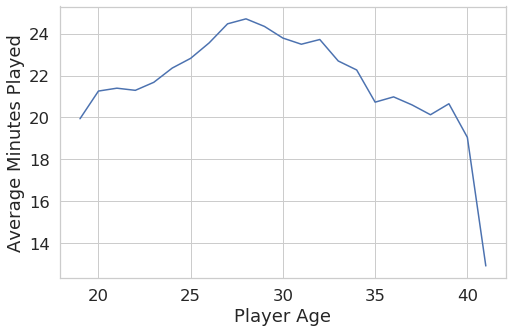

In [6]:
#Creating a temporary dataframe to play wit visualiaztions and stuff. Grabbing a few columns.
temp = pBox_comp_simp[['gmDate', 'seasTyp', 'fNm', 'lNm','fullName', 'playMin', 'playPF','playBDate']]

#Small cleanup to make sure they values we have are datatypes we can combine numerically.
temp.loc[:,'playBDate'] = temp.loc[:,'playBDate'].apply(lambda x: int(x[0:4]))
temp.loc[:,'gmDate'] = temp.loc[:,'gmDate'].apply(lambda x: int(x[0:4]))

#Lets add the age of the players as a columns and see what we get.
age = temp.loc[:,'gmDate'] - temp.loc[:,'playBDate']
temp.insert(len(temp.columns),'age', age)

#Now to plot the players' age against the average minutes played for a player of that age.
gbAge = temp.groupby('age').aggregate(np.mean)
plt.figure(figsize=(8, 5))
plt.plot(gbAge.index, gbAge['playMin'])
plt.xlabel(xlabel = 'Player Age')
plt.ylabel(ylabel = 'Average Minutes Played');



This plot shows a clear signal that there is a relationship between a player's age and the number of minutes they play. While peraps an obvious conclusion, the relationship is nontheless important to establish. Additionally, the presence of a clear peak around 26-28 years of age shows further value in this relationship. It might be more interesting to try and take a look at what a player's change in minutes played from season to season. 

In [7]:
tempNums = pBox_comp_simp[['gmDate','fullName', 'playMin', 'playPF', 'playWeight', 'playFG%']]
tempNums.loc[:,'gmDate'] = tempNums.loc[:,'gmDate'].apply(lambda x: int(x[0:4]))
#Let's see how many minutes a player has played each year.
playerMinutes = tempNums.pivot_table(values = 'playMin', index = 'fullName', columns = 'gmDate')

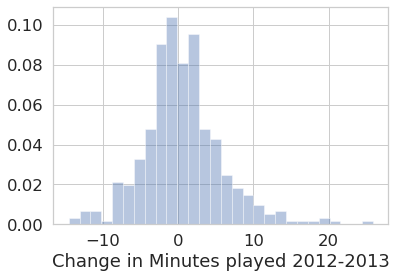

In [8]:
#Calculate the differences in minutes for players between 2013 and 2012
firstDiffs = playerMinutes[2013] - playerMinutes[2012]
sns.distplot(firstDiffs, hist = True, kde = False,norm_hist = True, axlabel = 'Change in Minutes played 2012-2013', );

OK so the distribution of differences in player minutes from one season to another is roughly centered at 0. This makes sense since there must be the same total minutes played every season, with small variation due to overtime games. Importantly we must note that the series we combined have many NaN values as of now because many players that exist in the dataset did not play in 2012 or 2013. We wil face a similar issue for later years when players present in early years retire. Now that we have some idea of a metric we want to predict (year-to-year minutes change), we will try to create a process to isolate that metric. We still need to consider what features might be important for predicting this value - we'll leave that for the model section. 

In [9]:
#create a function to isolate minDiff for a pBox dataframe.
def minDiff(y1, y2, df):
    simpDF = df[['gmDate','fullName', 'playMin']]
    simpPivot = df.pivot_table(values ='playMin', index = 'fullName', columns = 'gmDate')
    return simpPivot[y2] - simpPivot[y1]
#let's also create a helpful function to extract a numerical box score feature from the DF
def getStat(y, feature, df):
    year = df.loc[df['gmDate'] == y]
    year = year[['fullName', feature]]
    return year.groupby(by = 'fullName').apply(np.mean)[feature]


## Second Look: Career Stats

Now that we have generally cleaned our datasets, lets tidy it up a bit more. Here we will dive deeper in to the college dataset, which is a bit of a misnomer since it contains data for a player's NCAA *and* NBA history. Oh well. To gain a clearer picture, we'll only be looking at players that were active for more than one year and played in college as well as the NBA.

In [10]:
# Make a copy of the previous table to preserve efforts. 
# Add a column with career lengths, remove rows with a career length of zero
college_simp = college_comp_simp
college_simp['career_length'] = college_simp['active_to'] - college_simp['active_from']
college_simp = college_simp[college_simp['career_length'] > 1]
# If no college listed, replace NaN with 'None'
college_simp = college_simp.dropna(subset=['college'])
# Rename the columns (pct -> %) for clarity
college_simp = college_simp.rename(columns={'NCAA__3ptpct': 'NCAA__3pt%', 'NCAA_fgpct': 'NCAA__fg%', 
                                            'NCAA_ft': 'NCAA__ft%', 'NBA__3ptpct': 'NBA__3pt%'})
# Split on commas, find colleges that produced more than one player
college_simp['college'] = college_simp['college'].str.split(pat = ',').apply(lambda x: x[0])
good_cols = college_simp['college'].value_counts()[:(226 - 85)].index.to_list()
# college_simp = college_simp[college_simp['college'].isin(good_cols)]


/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Here's a little bonus! The chart below identifies the average career length per team. Good job Hampton University!

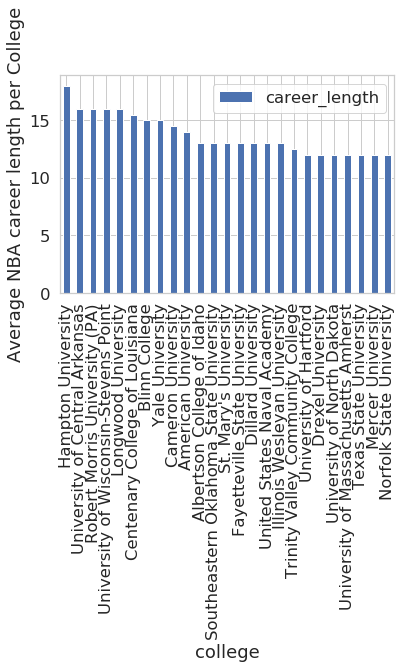

In [11]:
top_dogs = college_simp[['college', 'career_length']].groupby('college').mean().sort_values('career_length', ascending = False)

top_dogs.sort_values(by = 'career_length', ascending  = False).head(25).plot(kind = 'bar')
plt.ylabel(ylabel = 'Average NBA career length per College');




Let's leave this dataset as it is for now- we'll come back to a model design for it after we do the same for the first wing of our analysis.

# Model Design/Feature Engineering
## Creating the First Pipeline

Now that we have a few useful functions on our hands we can use them in a larger function that we can then apply to the whole pBoxScore dataframe. Ultimately our goal is to create entries of **season to season minute differences** with associated features. These will be unique to 1 player and one pair of consecutive years. We will not consider entries where a player plays minutes in one season and not the following one (or prior). As a continuation of the steps we took in data cleaning, ultimately our model will be generated using data from pBox_comp and/or pBox_comp_simp. The features we look at will end up being the *averages* for a player in a season given the data we have

We will generate our test-train split after applying the data processing to the entire dataframe since the dataframe as it is does not actually represent the entries we will be looking at.


In [12]:
#quickly setup a pBox_comp copy with game date and birthday converted to year ints like we did in the EDA. Add in age as well.
pBox_num = pBox_comp.copy(deep = True)
pBox_num.loc[:,'playBDate'] = pBox_num.loc[:,'playBDate'].apply(lambda x: int(x[0:4]))
pBox_num.loc[:,'gmDate'] = pBox_num.loc[:,'gmDate'].apply(lambda x: int(x[0:4]))
age = pBox_num.loc[:,'gmDate'] - pBox_num.loc[:,'playBDate']
pBox_num.insert(len(temp.columns),'age', age)

#These feature arrays were altered throughout the modeling process as we tried different features.
numericalFeatures = ['playFG%', 'playWeight','playHeight', 'playPTS', 'playAST', 'playTO', 'playSTL', 'playBLK','playDRB', 'playORB','age' ]
metric = 'minDelta'
def dataProcess_1(df, numericalFeatures):
    #create an empty dataframe we can add features to.
    newFrame = pd.DataFrame(columns = numericalFeatures)
    newFrame.insert(len(newFrame.columns), metric, value = None)
    #We will be generating YTY difference sets for 2012-2017, one year pair at a time, and appending them together.
    for i in np.arange(2012, 2017):
        minDelta = minDiff(i, i+1, df)
        #temporary DF that will contain all entries for one year
        tempDF = pd.DataFrame(data = minDelta, columns = [metric])
        #Now grab the features for a specific year and slap them into the temporary DF we have.
        for feature in numericalFeatures:
            featureSeries = getStat(i, feature, df)
            tempDF[feature] = featureSeries
        #append to the cumulative dataframe we have, after resetting index and dropping name.
        tempDF = tempDF.reset_index()
        tempDF = tempDF.drop(labels = ['fullName'], axis = 1)
        newFrame = newFrame.append(tempDF,ignore_index = True, sort = True)
    return newFrame
        
        

PHEW. We did that. Now we will apply the function to the entire pBox_num dataset followed by splitting into test and training data. We will be using a 90/10 train-test split. The processing function as we have it outputs rows with NaN values for any entry where a player played one year, but not the other for a consecutive year-pair. This will allow for easy filtering of entries we will use. Note that this means we are not capturing data for players who retured (the maximum loss in munutes essentially). We may come back to this issue later to find a solution.

We will be using a set random state for reproducibility when grading.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
state = 42

processedData = dataProcess_1(pBox_num, numericalFeatures)

In [14]:
#Conduting train test split in different cell to avoid reprocessing.
refinedData = processedData.dropna(thresh = len(processedData.columns))
train, test = train_test_split(refinedData, test_size = .15, random_state = state)
#Set up training DFs for fitting.
x_train = train.drop(labels = ['minDelta'], axis = 1); x_test = test.drop(labels = ['minDelta'], axis = 1);
#Set up test DFs for fitting.
y_train = train[['minDelta']]; y_test = test[['minDelta']]

Now we've established our training and testing sets, as well as cleaned up any entries that don't meet our criteria. The sets we are working with are now relatively small compared to what we started from, but the benefit is they provide relatively targeted and useful information. Now we will define a score function (RMSE), and fit our initial model with the features from our first data processing function. We will be using a linear regression model, courtesy of SKlearn.

In [15]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

firstModel = LinearRegression()
firstModel.fit(x_train, y_train)
print('The RMSE for the first model is :', rmse(y_train['minDelta'].values, firstModel.predict(x_train)))
print('The adjusted r^2 for the first model is :', firstModel.score(x_train, y_train))


The RMSE for the first model is : 6.008716281943584
The adjusted r^2 for the first model is : 0.16611427606258755


OK! We have our first model that tries to predict the change in a player's minutes based on single season stats. Our RMSE however, is very high and the r^2 value is very low. Evidently this is not a good model at all. This one isn't even worth cross-validating. Next we will standardize our data and attempt some feature engineering using the features we have to attmempt to improve this model, before looking at other possible statistics from the box score set.

In [16]:
#Utilizing preprocessing utilities from SKlearn.
from sklearn import preprocessing

#scale, or standardize our dataframes. They are now arrays.
x_trScaled = preprocessing.scale(x_train); x_teScaled = preprocessing.scale(x_test)
y_trScaled = preprocessing.scale(y_train); y_teScaled = preprocessing.scale(y_test)
standardizedModel = LinearRegression()
standardizedModel.fit(x_trScaled, y_trScaled)

print('The RMSE for the first model is :', rmse(y_trScaled, standardizedModel.predict(x_trScaled)))
print('The adjusted r^2 for the first model is :', standardizedModel.score(x_trScaled, y_trScaled))

#computes the players' assists per turnover. 0 if the player has no turnovers
def astto_ratio(df):
    ratio = df['playAST'] / (df['playTO'] + 1)
    return ratio
#computes the plaers' points scored per field goal attempted. 
def ppshot(df):
    return np.mean(df['playPTS']) / np.mean(df['playFGA'])
#computes a players number of wins in a season.
def wins(df):
    t = df.replace(to_replace = {'teamRslt' : {'Loss': 0 , 'Win': 1}})
    return sum(t['teamRslt'])
#computes the fraction of games a player started.    
def start(df):
    t = df.replace(to_replace = {'playStat' : {'Bench': 0 , 'Starter': 1}})
    return sum(t['playStat'])
#computes the number of fouls per minute committed by a player.
def fpm(df):
    return np.mean(df['playPF']) / np.mean((df['playMin'] + 1))
#computes the player's weight to height ratio.
def whratio(df):
    return np.mean(df['playWeight']) / np.mean(df['playHeight'])
#applies the feature function to specified year for a box score csv. Generalization of previous getStat
def get_feature(y, df, func):
    year = df.loc[df['gmDate'] == y]
    year = year.groupby(by = ['fullName']).apply(np.mean)
    return func(year.copy())


featureFunctions = [astto_ratio, ppshot,  fpm, whratio]
functionNames = ['ast/to', 'ppshot','fpm','whratio']


def convert_strings(df):
    t = df.replace(to_replace = {'teamRslt' : {'Loss': 0 , 'Win': 1}})
    t = df.replace(to_replace = {'playStat' : {'Bench': 0 , 'Starter': 1}})
    return t

The RMSE for the first model is : 0.9131734358474366
The adjusted r^2 for the first model is : 0.16611427606258752


Standardization by itself does not improve our model by very much—note that the adjustd r^s is still very low. Above we have defined a few functions to help generate some more features from our data. In order to include them we'll need to create a second data processing function. The feature functions we created above compile averages for a player-year. In our new data processing function we will also include the null value cleaning we developed above.

In [17]:
#more complete and complex data processing function. Similar process to previous one. Changes highlighted.
def dataProcess_2(df, numericalFeatures, featureFunctions,functionNames):
    allFeatures = list(numericalFeatures).extend(functionNames)
    newFrame = pd.DataFrame(columns = allFeatures)
    newFrame.insert(len(newFrame.columns), metric, value = None)
    df = convert_strings(df)
    for i in np.arange(2012, 2017):
        minDelta = minDiff(i, i+1, df)
        #temporary DF that will contain all entries for one year
        tempDF = pd.DataFrame(data = minDelta, columns = [metric])
        #Now grab the features, including features we will construct. 
        for feature in numericalFeatures:
            featureSeries = getStat(i,  feature, df)
            tempDF[feature] = featureSeries
        #Now our constructed features.
        for k in np.arange(len(functionNames)):
            temp2 = df.loc[df['gmDate'] == i]
            temp2 = temp2.groupby(by = ['fullName']).apply(np.mean)
            series = featureFunctions[k](temp2)
            tempDF[functionNames[k]] =  series
        #Now the string functions that are a little finnicky.
        temp3 = df.copy(deep = True).loc[df['gmDate'] == i]
        temp3 = temp3.groupby(by = ['fullName'])
        winSeries = temp3.apply(wins); tempDF['wins'] = winSeries
        #append to the cumulative dataframe we have, after resetting index and dropping name.
        tempDF = tempDF.reset_index()
        tempDF = tempDF.drop(labels = ['fullName'], axis = 1)
        newFrame = newFrame.append(tempDF,ignore_index = True, sort = True)
    #include NA dropping
    return newFrame.dropna(thresh = len(newFrame.columns))

Now to see it in action. Note that this takes ~5 minutes to run.

In [ ]:
#Let's add the necessary columns to a new player box score dataframe.
pBox2 = pBox_comp.copy(deep = True)
pBox2.loc[:,'playBDate'] = pBox2.loc[:,'playBDate'].apply(lambda x: int(x[0:4]))
pBox2.loc[:,'gmDate'] = pBox2.loc[:,'gmDate'].apply(lambda x: int(x[0:4]))
age = pBox2.loc[:,'gmDate'] - pBox2.loc[:,'playBDate']
pBox2.insert(len(temp.columns),'age', age)

processed2 = dataProcess_2(pBox_num, numericalFeatures, featureFunctions, functionNames)

In [ ]:
train2, test2 = train_test_split(processed2, test_size = .15, random_state = state)
#Set up training DFs for fitting.
x_train2 = train2.drop(labels = ['minDelta'], axis = 1); x_test2 = test2.drop(labels = ['minDelta'], axis = 1);
#Set up test DFs for fitting.
y_train2 = train2[['minDelta']]; y_test2 = test2[['minDelta']]

In [ ]:
#Set up the model

secondModel = LinearRegression()
secondModel.fit(x_train2, y_train2)
print('The RMSE for the second model is :', rmse(y_train2['minDelta'].values, secondModel.predict(x_train2)))
print('The adjusted r^2 for the second model is :', secondModel.score(x_train2, y_train2))



The RMSE for the first model is : 6.075133764638787
The adjusted r^2 for the first model is : 0.19203609391522103

Not great. Now we're going to perform some cross-validation on our model to see how it might perform on the test-set.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

cv_error = cross_validate_rmse(secondModel, x_train2, y_train2)
print("Cross Validation RMSE: {}".format(cv_error))


It appears that our model actually performed significantly better in the cross-validation test. It would appear that the features we selected for our model ultimately ended up generalizing better than they fit the training data. This may be due to the random state we set coincidentally having given us a strange subset of the data for our training.

Cross Validation RMSE: 5.01603800209176

Let's check out the performance on the test set.

In [ ]:
test_error = rmse(y_test2['minDelta'].values, secondModel.predict(x_test2))
print("Test RMSE: {}".format(test_error))

Interesting! Ultimately on our test data we've obrained a similar error to the one we got on the training data. This supports the idea that the cross validation had something strange go on with its split. Before going into more discussion we will attempt to look at longevity at the career scale.

Test RMSE: 6.12567960944949

## Beyond the Season: The Second Pipeline

Next we will attempt to look at players' entire career data in an attempt to predict the longevity of their career (years played) from career statistics from college and the NBA. Although a retrospective, we believe this experiment might allow us to gain insight into what characteristics are shared by players with long careers, and what could be important things for younger players to focus on.

Since a player's college of origin and position may play a part in how long they ended up playing in the NBA, one of the things we'll be doing will be to one-hot encode these values.

In [ ]:
# Quick one hot encode for colleges and position
hot_enc_col = pd.get_dummies(college_simp['college'])
hot_enc_pos = pd.get_dummies(college_simp['position'])

We will now grab the features that do not require one-hot-encoding, imputing missing values with the mean of the column. This is mostly necessary in case there are still players for whom 3-point information was not recorded. Similarly, NCAA data was occasioanlly spotty

In [ ]:
# non-player features, including the target column
player_features = college_simp[['career_length', 'weight']]

# Create table of features: relevant player stats, college, and position
stat_features = college_simp[['NBA__3pt%', 'NBA_fg%', 'NBA_ft%', 'NBA_g_played', 
                              'NBA_ppg', 'NCAA__3pt%', 'NCAA__fg%', 'NCAA__ft%']]
# Fill nans with the mean
fill_mean = lambda x: stat_features.loc[:, x].fillna(stat_features[x].mean())
stat_features.loc[:, 'NBA__3pt%'] =  fill_mean('NBA__3pt%')
stat_features.loc[:, 'NBA_fg%'] =  fill_mean('NBA_fg%')
stat_features.loc[:, 'NBA_ft%'] =  fill_mean('NBA_ft%')
stat_features.loc[:, 'NBA_g_played'] = fill_mean('NBA_g_played')
stat_features.loc[:, 'NBA_ppg'] =  fill_mean('NBA_ppg')
stat_features.loc[:, 'NCAA__3pt%'] = fill_mean('NCAA__3pt%')
stat_features.loc[:, 'NCAA__fg%'] = fill_mean('NCAA__fg%')
stat_features.loc[:, 'NCAA__ft%'] = fill_mean('NCAA__ft%')

features = pd.concat([player_features, stat_features, hot_enc_pos, hot_enc_col], axis= 1)

OK! Now that we have a dataset that's ready, let's put it into a **linear model** and see what kind of predictive power we achieve.

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def cross_validate_rmse(model):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(tr):
        model.fit(tr.iloc[tr_ind,:], tr['mpg'].iloc[tr_ind])
        rmse_values.append(rmse(tr['mpg'].iloc[va_ind], model.predict(tr.iloc[va_ind,:])))
    return np.mean(rmse_values)


# Split DF into train and test sets
train, test = train_test_split(features, test_size=0.15)

# Function to grab the X columns and Y columns
X = lambda df: df.loc[:, 'NCAA__3pt%':]
Y = lambda df: df.loc[:, 'career_length']

# x_train = scale(X(train)); x_test = scale(X(test))
# y_train = scale(Y(train)); y_test = scale(Y(test))

In [ ]:
# Fit to Linear Regression model
lin_model = LinearRegression()
lin_model.fit(X(train), Y(train))
lin_pred = lin_model.predict(X(test))
rmse(lin_pred, Y(test))

Yikes. Not very good at all. There is a fundamental issue with this model and the features. The RMSE and r^2 are not worth examining given the clear uselessness of the model.

# Discussion

Evidently there were some clear issues with the models generated for both questions we attempted to answer. Both models generated large errors, with the career-length predictor essentially being useless. The implications of some of these results as well as next steps are discussed in the writeup.